<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.18.0
TFP version: 0.25.0


# Variational autoencoders

## Coding tutorials

#### [1. Encoders and decoders](#tutorial1)
#### [2. Minimising Kullback-Leibler divergence](#tutorial2)
#### [3. Maximising the ELBO](#tutorial3)
#### [4. KL divergence layers](#tutorial4)

***
<a class="anchor" id="tutorial1"></a>
## Encoders and decoders

In [ ]:
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=[28, 28]),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=2)
])
decoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=2),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=28*28, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Reshape(target_shape=[28, 28])
])

autoencoder = tf_keras.Model(
    inputs=encoder.inputs,
    outputs=decoder(inputs=encoder.outputs)
)
autoencoder.compile(
    loss=tf_keras.losses.MeanSquaredError(),
    optimizer=tf_keras.optimizers.RMSprop()
)

x_train = tf.random.normal(shape=[3, 28, 28], dtype=tf.float32)
autoencoder.fit(x=x_train, y=x_train, epochs=3)

# x_test: (1, 28, 28)
x_test = tf.random.normal(shape=[1, 28, 28], dtype=tf.float32)
reconstruction = autoencoder(inputs=x_test)

x_encoded = encoder(inputs=x_test)
z_decoded = decoder(inputs=x_encoded)

tf.norm(tensor=reconstruction - z_decoded)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 1.2077
Epoch 2/3
1/1 [==============================] - 0s 7ms/step - loss: 1.1747
Epoch 3/3
1/1 [==============================] - 0s 6ms/step - loss: 1.1454


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
# Load Fashion MNIST
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt',
    'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

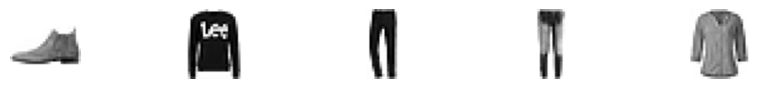

In [ ]:
# Display a few examples
import matplotlib.pyplot as plt

n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[9, 1])
for j in range(len(axes)):
    axes[j].imshow(X=example_images[j], cmap='binary')
    axes[j].axis('off')
fig.tight_layout()
fig.show()

In [ ]:
# Define the encoder
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

encoded_dim = 2
encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=[28, 28]),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=encoded_dim)
])
encoder.layers

In [ ]:
# Encode examples before training
pretrain_example_encodings = encoder(inputs=example_images)
pretrain_example_encodings.shape

TensorShape([1000, 2])

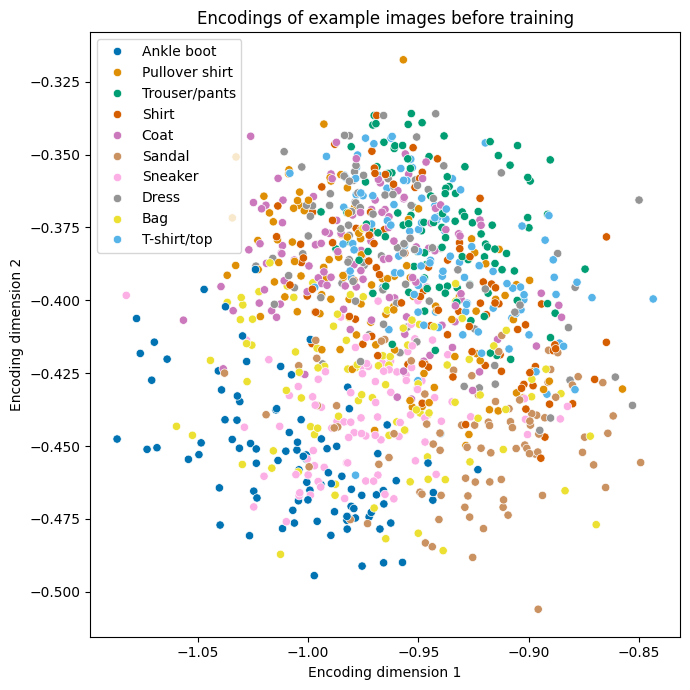

In [ ]:
# Plot encoded examples before training
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 7])
sns.scatterplot(ax=ax, hue=class_names[example_labels],
    x=pretrain_example_encodings[:, 0],
    y=pretrain_example_encodings[:, 1],
    palette=sns.color_palette(palette='colorblind', n_colors=10)
)
ax.set_xlabel(xlabel='Encoding dimension 1')
ax.set_ylabel(ylabel='Encoding dimension 2')
ax.set_title(label='Encodings of example images before training')
fig.tight_layout()
fig.show()

In [ ]:
# Define the decoder
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

decoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=encoded_dim),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=28*28, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Reshape(target_shape=[28, 28])
])
decoder.layers

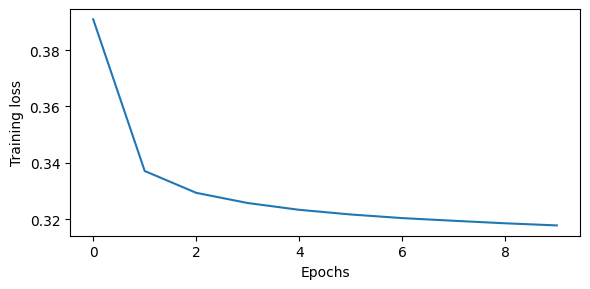

In [ ]:
# Compile and fit the model
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

autoencoder = tf_keras.Model(
    inputs=encoder.inputs,
    outputs=decoder(inputs=encoder.outputs)
)

# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss
autoencoder.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf_keras.optimizers.Adam()
)

# Fit model - highlight that labels and input are the same
history = autoencoder.fit(x=x_train, y=x_train, epochs=10, batch_size=32, verbose=False)
train_losses = history.history['loss']
plt.figure(figsize=[6, 3])
plt.plot(train_losses)
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='Training loss')
plt.tight_layout()
plt.show()

In [ ]:
# Compute example encodings after training
posttrain_example_encodings = encoder(inputs=example_images)
posttrain_example_encodings.shape

TensorShape([1000, 2])

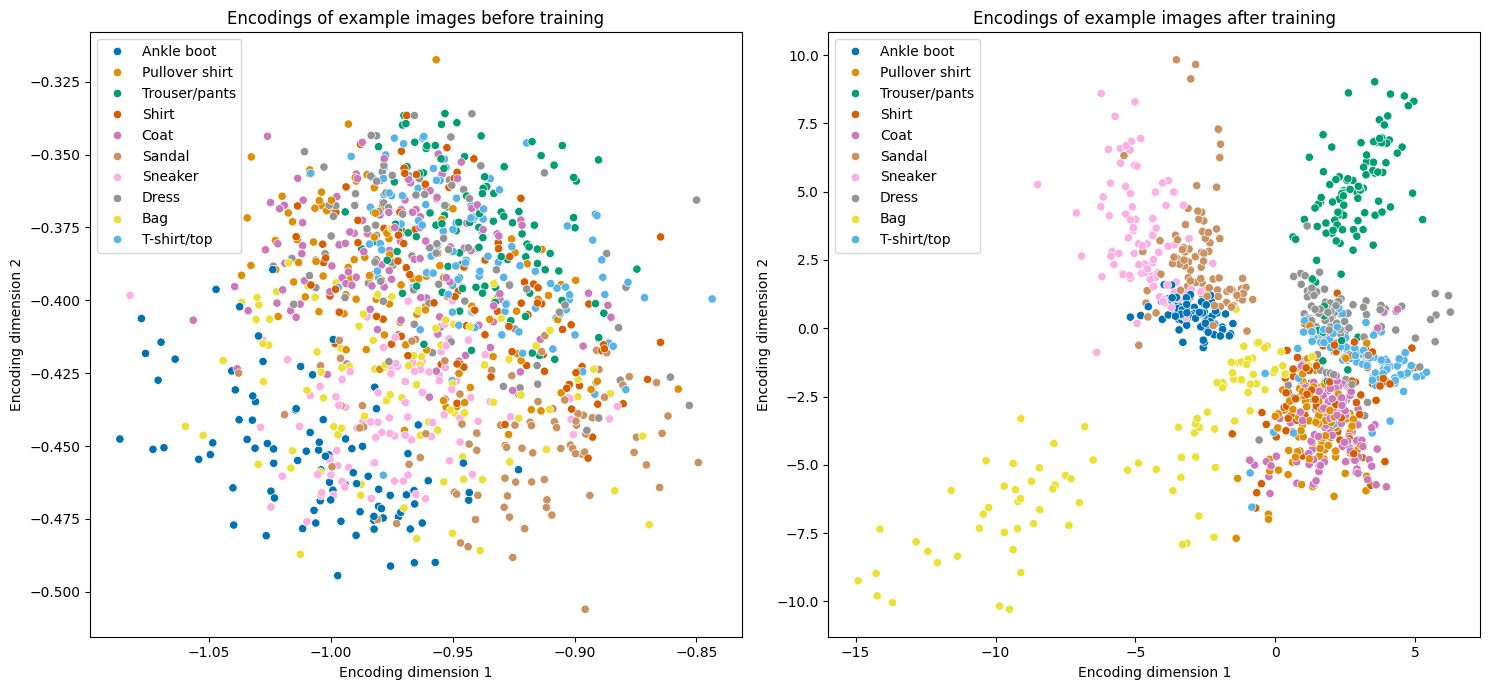

In [ ]:
# Compare the example encodings before and after training
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 7])
sns.scatterplot(ax=axes[0], hue=class_names[example_labels],
    x=pretrain_example_encodings[:, 0],
    y=pretrain_example_encodings[:, 1],
    palette=sns.color_palette(palette='colorblind', n_colors=10)
)
sns.scatterplot(ax=axes[1], hue=class_names[example_labels],
    x=posttrain_example_encodings[:, 0],
    y=posttrain_example_encodings[:, 1],
    palette=sns.color_palette(palette='colorblind', n_colors=10)
)
axes[0].set_title(label='Encodings of example images before training');
axes[1].set_title(label='Encodings of example images after training');
for ax in axes:
    ax.set_xlabel(xlabel='Encoding dimension 1')
    ax.set_ylabel(ylabel='Encoding dimension 2')
fig.tight_layout()
fig.show()

In [ ]:
# Compute the autoencoder's reconstructions
reconstructed_example_images = autoencoder(inputs=example_images)
reconstructed_example_images.shape

TensorShape([1000, 28, 28])

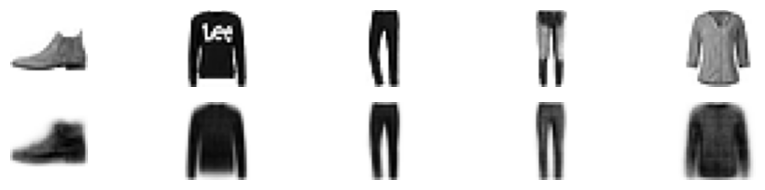

In [ ]:
# Evaluate the autoencoder's reconstructions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[9, 2])
for j in range(5):
    axes[0, j].imshow(X=example_images[j], cmap='binary')
    axes[1, j].imshow(X=reconstructed_example_images[j], cmap='binary')
    axes[0, j].axis('off')
    axes[1, j].axis('off')
fig.tight_layout()
fig.show()

***
<a class="anchor" id="tutorial2"></a>
## Minimising Kullback-Leibler divergence

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

# KL(q || p) = E_{z ~ q}[log q(z) - log p(z)]

# tfp.bijectors.Chain(bijectors=[
#     tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Chain(bijectors=[
#         tfp.bijectors.Shift(shift=1e-5),
#         tfp.bijectors.Softplus()])),
#     tfp.bijectors.FillTriangular()
# ])

scale_tril = tfp.bijectors.FillScaleTriL().forward(x=[-0.5, 1.25, 1.])
p = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=scale_tril)

q = tfp.distributions.MultivariateNormalDiag(
    loc=tf.Variable(initial_value=tf.random.normal(shape=[2])),
    scale_diag=tfp.util.TransformedVariable(initial_value=tf.random.uniform(shape=[2]),
        bijector=tfp.bijectors.Exp())
)

@tf.function(reduce_retracing=True)
def loss_and_grads(q, p):
    with tf.GradientTape() as tape:
        loss = tfp.distributions.kl_divergence(distribution_a=q, distribution_b=p)
    grads = tape.gradient(target=loss, sources=q.trainable_variables)
    return loss, grads

opt = tf.keras.optimizers.Adam()
for _ in range(3):
    loss, grads = loss_and_grads(q=q, p=p)
    opt.apply_gradients(grads_and_vars=zip(grads, q.trainable_variables))
    print('loss:', loss)

loss: tf.Tensor(4.2332563, shape=(), dtype=float32)
loss: tf.Tensor(4.221829, shape=(), dtype=float32)
loss: tf.Tensor(4.2104254, shape=(), dtype=float32)


In [ ]:
# Define a target distribution, p
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

p_mu = 0.
p_L = tfp.bijectors.Chain(bijectors=[
    tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Softplus()),
    tfp.bijectors.FillTriangular()
]).forward(x=tf.random.uniform(shape=[3]))
p = tfp.distributions.MultivariateNormalTriL(loc=p_mu, scale_tril=p_L)
p

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

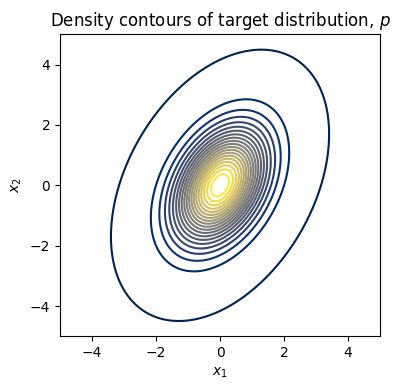

In [ ]:
# Plot the target distribution's density contours
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
    Plots the contours of a bivariate TensorFlow density function
    (i.e. .prob()). X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(a=density(X).numpy(), newshape=X1.shape)

    if ax==None:
        _, ax = plt.subplots(figsize=(4, 4))

    ax.contour(X1, X2, density_values, **contour_kwargs)
    return ax

x1 = np.linspace(start=-5, stop=5, num=1000, dtype=np.float32)
x2 = np.linspace(start=-5, stop=5, num=1000, dtype=np.float32)
X1, X2 = np.meshgrid(x1, x2)
# Density contours are linearly spaced specific to this seed
contour_levels = np.linspace(start=1e-4, stop=10**(-0.8), num=20, dtype=np.float32)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
ax = plot_density_contours(ax=ax, density=p.prob, X1=X1, X2=X2,
    contour_kwargs={'levels':contour_levels, 'cmap':'cividis'})
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5);
ax.set_title(label='Density contours of target distribution, $p$')
ax.set_xlabel(xlabel='$x_1$'); ax.set_ylabel(ylabel='$x_2$');
fig.tight_layout()
fig.show()

In [ ]:
# Initialize an approximating distribution, q, that has diagonal covariance
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

q = tfp.distributions.MultivariateNormalDiag(
    loc=tf.Variable(initial_value=tf.random.normal(shape=[2])),
    scale_diag=tfp.util.TransformedVariable(initial_value=tf.random.uniform(shape=[2]),
        bijector=tfp.bijectors.Exp()))
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
# Define a function for the Kullback-Leibler divergence
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

@tf.function(reduce_retracing=True)
def loss_and_grads(dist_a, dist_b):
    with tf.GradientTape() as tape:
        loss = tfp.distributions.kl_divergence(distribution_a=dist_a,
            distribution_b=dist_b)
    grads = tape.gradient(target=loss, sources=dist_a.trainable_variables)
    return loss, grads

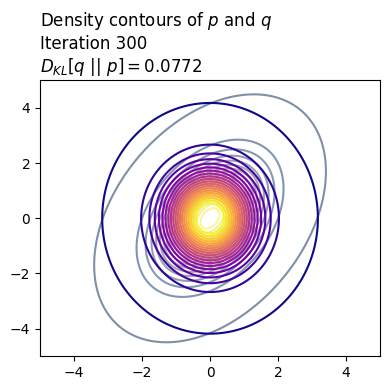

In [ ]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients
import numpy as np
np.random.seed(seed=42)
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt
from IPython import display

num_train_steps = 300
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):

    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(dist_a=q, dist_b=p)

    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(grads_and_vars=zip(grads, q.trainable_variables))

    # Plot the updated density
    if ((i + 1) % 10 == 0):
        display.clear_output(wait=True)
        ax = plot_density_contours(density=p.prob, X1=X1, X2=X2,
            contour_kwargs={'levels':contour_levels, 'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(ax=ax, density=q.prob, X1=X1, X2=X2,
            contour_kwargs={'levels':contour_levels, 'cmap':'plasma'})
        ax.set_title(label='Density contours of $p$ and $q$\n' + 'Iteration '
            + str(i + 1) + '\n' + '$D_{KL}[q \ || \ p] = '
            + str(np.round(a=q_loss.numpy(), decimals=4)) + '$', loc='left')
        plt.tight_layout()
        plt.show()
        plt.pause(interval=.01)

In [ ]:
# Re-fit the distribution, this time fitting q_rev by minimising KL[p || q_rev]
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

q_rev = tfp.distributions.MultivariateNormalDiag(
    loc=tf.Variable(initial_value=tf.random.normal(shape=[2])),
    scale_diag=tfp.util.TransformedVariable(initial_value=tf.random.uniform(shape=[2]),
        bijector=tfp.bijectors.Exp()))
q_rev

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
# Edit loss_and_grads function
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

@tf.function(reduce_retracing=True)
def loss_and_grads(dist_a, dist_b, reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfp.distributions.kl_divergence(distribution_a=dist_a,
                distribution_b=dist_b)
        else:
            loss = tfp.distributions.kl_divergence(distribution_a=dist_b,
                distribution_b=dist_a)
    grads = tape.gradient(target=loss, sources=dist_a.trainable_variables)
    return loss, grads

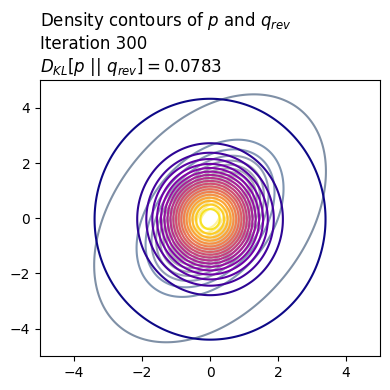

In [ ]:
# Re-initialize optimizer, run training loop
import numpy as np
np.random.seed(seed=42)
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt
from IPython import display

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev]
    q_rev_loss, grads = loss_and_grads(dist_a=q_rev, dist_b=p, reverse=True)

    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(grads_and_vars=zip(grads, q_rev.trainable_variables))

    # Plot the updated density
    if ((i + 1) % 10 == 0):
        display.clear_output(wait=True)
        ax = plot_density_contours(density=p.prob, X1=X1, X2=X2,
            contour_kwargs={'levels':contour_levels, 'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(ax=ax, density=q_rev.prob, X1=X1, X2=X2,
            contour_kwargs={'levels':contour_levels, 'cmap':'plasma'})
        ax.set_title(label='Density contours of $p$ and $q_{rev}$\n' + 'Iteration '
            + str(i + 1) + '\n' + '$D_{KL}[p \ || \ q_{rev}] = ' +
            str(np.round(a=q_rev_loss.numpy(), decimals=4)) + '$', loc='left')
        plt.tight_layout()
        plt.show()
        plt.pause(interval=.01)

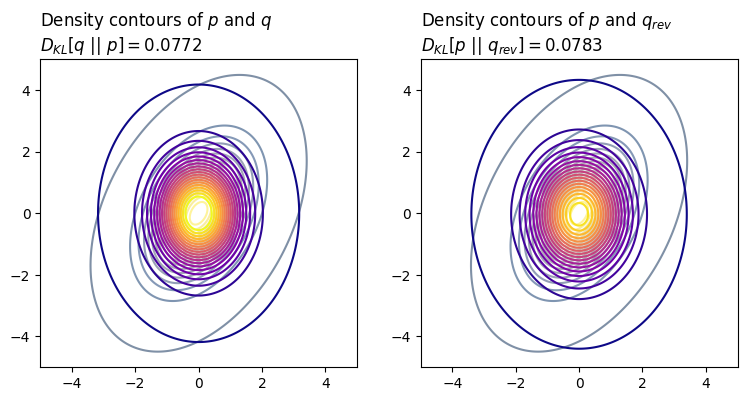

In [ ]:
# Plot q and q_rev alongside one another
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[9, 4])
axs[0] = plot_density_contours(ax=axs[0], density=p.prob, X1=X1, X2=X2,
    contour_kwargs={'levels':contour_levels, 'cmap':'cividis', 'alpha':0.5})
axs[0] = plot_density_contours(ax=axs[0], density=q.prob, X1=X1, X2=X2,
    contour_kwargs={'levels':contour_levels, 'cmap':'plasma'})
axs[0].set_title(loc='left', label='Density contours of $p$ and $q$\n'
    + '$D_{KL}[q \ || \ p] = ' + str(np.round(a=q_loss.numpy(), decimals=4)) + '$')

axs[1] = plot_density_contours(ax=axs[1], density=p.prob, X1=X1, X2=X2,
    contour_kwargs={'levels':contour_levels, 'cmap':'cividis', 'alpha':0.5})
axs[1] = plot_density_contours(ax=axs[1], density=q_rev.prob, X1=X1, X2=X2,
    contour_kwargs={'levels':contour_levels, 'cmap':'plasma'})
axs[1].set_title(loc='left', label='Density contours of $p$ and $q_{rev}$\n' +
    '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(a=q_rev_loss.numpy(), decimals=4)) + '$');

---
<a class="anchor" id="tutorial3"></a>
## Maximising the ELBO

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

\begin{align*}
\log p(x) &\geq \mathbb{E}_{Z \sim q(z|x)}\big[\ −\log q(Z|x) + \log p(x, Z) \ \big]\\
&= - \mathrm{D}_\mathrm{KL}\big[\ q(z|x) \ || \ p(z) \ \big] + \mathbb{E}_{Z \sim q(z|x)}\big[ \log p(x|Z) \big]
\end{align*}

In [ ]:
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# encoder(x) = q(z|x) ~= p(z|x)
# z ~ N(0, I) = p(z)
# p(x|z) = decode(z)
# x ~ p(x|z)

# log p(x) >= E_{z ~ q(z|x)}[-log q(z|x) + log p(x, z)]
# = -D_{KL}(q(z|x) || p(z)) + E_{z ~ q(z|x)}[log p(x|z)] (ELBO)

latent_size = 2
event_shape = [28, 28, 1]
encoder = tf_keras.Sequential(name='encoder', layers=[
    tf_keras.Input(shape=event_shape),
    tf_keras.layers.Conv2D(filters=8, kernel_size=[5, 5], strides=2,
        activation=tf.keras.activations.tanh),
    tf_keras.layers.Conv2D(filters=8, kernel_size=[5, 5], strides=2,
        activation=tf.keras.activations.tanh),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.tanh),
    tf_keras.layers.Dense(units=2*latent_size),
    tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
        tfp.distributions.MultivariateNormalDiag(loc=t[..., :latent_size],
            scale_diag=tf.math.exp(x=t[..., latent_size:])))
])
decoder = tf_keras.Sequential(name='decoder', layers=[
    tf_keras.Input(shape=latent_size),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.tanh),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.tanh),
    tf_keras.layers.Reshape(target_shape=[4, 4, 8]),
    tf_keras.layers.Conv2DTranspose(filters=8, kernel_size=[5, 5], strides=2,
        output_padding=1, activation=tf.keras.activations.tanh),
    tf_keras.layers.Conv2DTranspose(filters=8, kernel_size=[5, 5], strides=2,
        output_padding=1, activation=tf.keras.activations.tanh),
    tf_keras.layers.Conv2D(filters=1, kernel_size=[3, 3], padding='SAME'),
    tf_keras.layers.Flatten(),
    tfp.layers.IndependentBernoulli(event_shape=event_shape)
])

prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(shape=latent_size))

def loss_fn(x_true, approx_posterior, x_pred, prior_dist):
    reconstruction_loss = -x_pred.log_prob(value=x_true)
    kl_loss = tfp.distributions.kl_divergence(distribution_a=approx_posterior,
        distribution_b=prior_dist)
    return tf.math.reduce_mean(input_tensor=kl_loss + reconstruction_loss)

# Monte Carlo
def loss_fn_MC(x_true, approx_posterior, x_pred, prior_dist):
    reconstruction_loss = -x_pred.log_prob(value=x_true)
    approx_posterior_sample = approx_posterior.sample()
    kl_approx = (approx_posterior.log_prob(value=approx_posterior_sample)
        - prior_dist.log_prob(value=approx_posterior_sample))
    return tf.math.reduce_mean(input_tensor=kl_approx + reconstruction_loss)

@tf.function(reduce_retracing=True)
def get_loss_and_grads(x, encoder, decoder, prior):
    with tf.GradientTape() as tape:
        approx_posterior = encoder(inputs=x)
        approx_posterior_sample = approx_posterior.sample()
        x_pred = decoder(inputs=approx_posterior_sample)
        loss = loss_fn(x_true=x, approx_posterior=approx_posterior,
            x_pred=x_pred, prior_dist=prior)
    grads = tape.gradient(target=loss, sources=
        encoder.trainable_variables + decoder.trainable_variables)
    return loss, grads

x_train = tf.random.normal(shape=[64, 28, 28, 1], dtype=tf.float32)
x_train = tf.data.Dataset.from_tensor_slices(tensors=x_train).batch(batch_size=32)

opt = tf_keras.optimizers.Adam()
for i in range(3):
    for x in x_train:
        loss, grads = get_loss_and_grads(x=x, encoder=encoder, decoder=decoder,
            prior=prior)
        opt.apply_gradients(grads_and_vars=zip(grads,
            encoder.trainable_variables + decoder.trainable_variables))
    print('-ELBO after epoch %d: %.2f'%(i+1, loss.numpy()))

z = prior.sample(sample_shape=[3]) #(3, 2)
x_generated = decoder(inputs=z).sample() #(3, 28, 28, 1)
print('Generated shape:', x_generated.shape)

def vae(inputs):
    approx_posterior = encoder(inputs=inputs)
    decoded = decoder(inputs=approx_posterior.sample())
    return decoded.mean()

x_test = tf.random.normal(shape=[1, 28, 28, 1], dtype=tf.float32)
z = encoder(inputs=x_test) #(1, 28, 28, 1)
x_decoded = decoder(inputs=z.sample()).mean()

reconstruction = vae(inputs=x_test) #(1, 28, 28, 1)
tf.norm(tensor=reconstruction - x_decoded)

-ELBO after epoch 1: 541.98
-ELBO after epoch 2: 536.95
-ELBO after epoch 3: 530.49
Generated shape: (3, 28, 28, 1)


<tf.Tensor: shape=(), dtype=float32, numpy=0.5232442617416382>

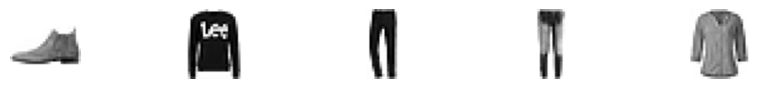

In [1]:
# Import Fasion MNIST, make it a TensorFlow Dataset
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:1000]
example_y = y_test[:1000]

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt',
    'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(tensors=x_train)\
    .batch(batch_size=batch_size)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[9, 1])
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X=example_x[i], cmap='binary')
    ax.axis('off')
fig.tight_layout()
fig.show()

In [2]:
# Define the encoding distribution, q(z|x)
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

latent_size = 2
event_shape = [28, 28]
encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=event_shape),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=2*latent_size),
    tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
        tfp.distributions.MultivariateNormalDiag(loc=t[..., :latent_size],
            scale_diag=tf.math.exp(x=t[..., latent_size:])))
])

# Pass an example image through the network - should return a batch of MultivariateNormalDiags.
pretrain_example_encodings = encoder(inputs=example_x)
pretrain_example_encodings

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[2] dtype=float32>

In [3]:
# Define the decoding distribution, p(x|z)
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

decoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=latent_size),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=256, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.IndependentBernoulli.params_size(
        event_shape=event_shape)),
    tfp.layers.IndependentBernoulli(event_shape=event_shape)
])

# Pass a batch of examples to the decoder
decoder(inputs=pretrain_example_encodings)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[28, 28] dtype=float32>

In [4]:
# Define the prior, p(z) - a standard bivariate Gaussian
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(shape=latent_size))
prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

The loss function we need to estimate is

\begin{equation*}
-\mathrm{ELBO} = \mathrm{D}_\mathrm{KL} \big[ \ q(z|x) \ || \ p(z) \ \big] - \mathbb{E}_{Z \sim q(z|x)}\big[ \log p(x|Z) \big]\\
\end{equation*}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation*}
\sum_j \mathrm{D}_\mathrm{KL} \big[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathbb{E}_{Z_j \sim q(z_j|x_j)}\big[ \log p(x_j|Z_j) \big]
\end{equation*}

In [5]:
# Specify the loss function, an estimate of the -ELBO
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

def loss_fn(x, encoding_dist, sampled_decoding_dist, prior):
    recon_loss = -sampled_decoding_dist.log_prob(value=x)
    kl_loss = tfp.distributions.kl_divergence(distribution_a=encoding_dist,
        distribution_b=prior)
    return tf.math.reduce_sum(input_tensor=kl_loss + recon_loss)

# -ELBO estimate using an estimate of the KL divergence
def loss_fn_MC(x, encoding_dist, sampled_decoding_dist, prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(value=x)
    kl_approx = (encoding_dist.log_prob(value=sampled_z) - prior.log_prob(value=sampled_z))
    return tf.math.reduce_sum(input_tensor=kl_approx + recon_loss)

In [6]:
# Define a function that returns the loss and its gradients
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

@tf.function(reduce_retracing=True)
def get_loss_and_grads(x, encoder, decoder, prior):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(inputs=x)
        sampled_z = encoding_dist.sample()
        sampled_decoding_dist = decoder(inputs=sampled_z)
        loss = loss_fn(x=x, encoding_dist=encoding_dist,
            sampled_decoding_dist=sampled_decoding_dist, prior=prior)

    grads = tape.gradient(target=loss, sources=
        encoder.trainable_variables + decoder.trainable_variables)
    return loss, grads

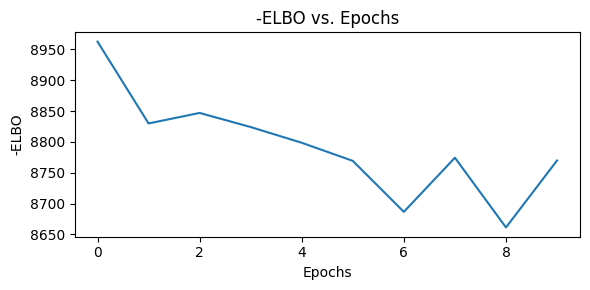

In [7]:
# Compile and train the model
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

num_epochs = 10
opt = tf_keras.optimizers.Adam()
losses = []
for i in range(num_epochs):
    for train_batch in x_train:
        loss, grads = get_loss_and_grads(x=train_batch, encoder=encoder,
            decoder=decoder, prior=prior)
        opt.apply_gradients(grads_and_vars=zip(grads,
            encoder.trainable_variables + decoder.trainable_variables))
    losses.append(loss.numpy())

plt.figure(figsize=[6, 3])
plt.plot(losses)
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='-ELBO')
plt.title(label='-ELBO vs. Epochs')
plt.tight_layout()
plt.show()

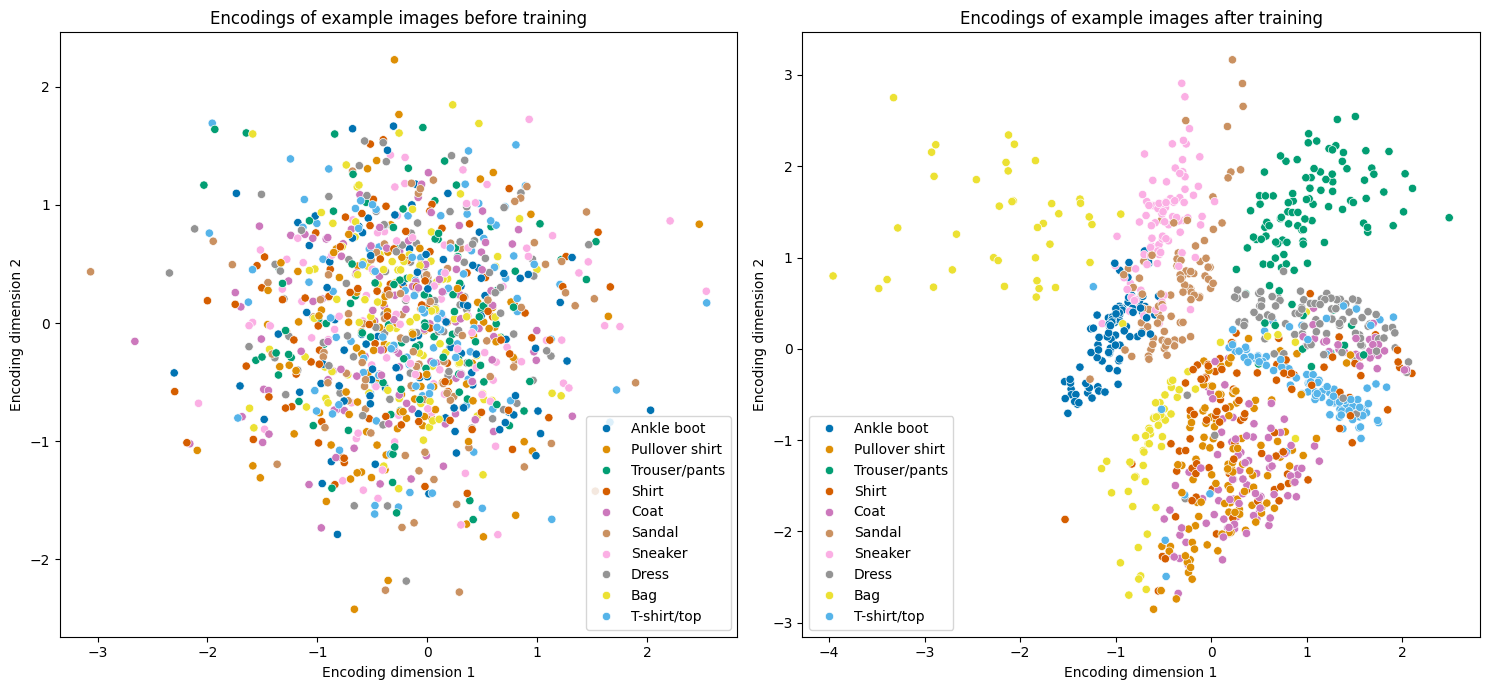

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute example encodings after training
posttrain_example_encodings = encoder(inputs=example_x)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 7])
sns.scatterplot(ax=axes[0], hue=class_names[example_y],
    x=pretrain_example_encodings[:, 0], y=pretrain_example_encodings[:, 1],
    palette=sns.color_palette(palette='colorblind', n_colors=10))
sns.scatterplot(ax=axes[1], hue=class_names[example_y],
    x=posttrain_example_encodings[:, 0], y=posttrain_example_encodings[:, 1],
    palette=sns.color_palette(palette='colorblind', n_colors=10))
axes[0].set_title(label='Encodings of example images before training')
axes[1].set_title(label='Encodings of example images after training')
for ax in axes:
    ax.set_xlabel(xlabel='Encoding dimension 1')
    ax.set_ylabel(ylabel='Encoding dimension 2')
fig.tight_layout()
fig.show()

In [9]:
# Connect encoder and decoder, compute a reconstruction
def vae(inputs):
    approx_posterior = encoder(inputs=inputs)
    decoding_dist = decoder(inputs=approx_posterior.sample())
    return decoding_dist.mean()

example_reconstruction = vae(inputs=example_x)
example_reconstruction.shape

TensorShape([1000, 28, 28])

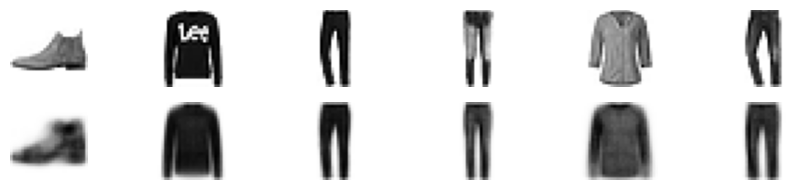

In [10]:
# Plot examples against reconstructions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=[9, 2])
for j in range(6):
    axs[0, j].imshow(X=example_x[j], cmap='binary')
    axs[1, j].imshow(X=example_reconstruction[j], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
fig.tight_layout()
fig.show()

In [11]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)
z = prior.sample(sample_shape=(6))
generated_x = decoder(inputs=z).mean()
generated_x.shape

TensorShape([6, 28, 28])

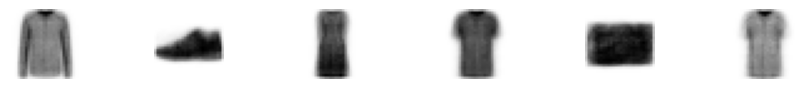

In [12]:
# Display generated_x
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=[9, 1])
for j in range(6):
    axs[j].imshow(X=generated_x[j], cmap='binary')
    axs[j].axis('off')
fig.tight_layout()
fig.show()

***
<a class="anchor" id="tutorial4"></a>
# KL divergence layers

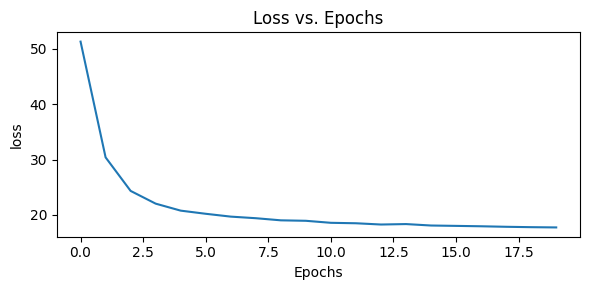

<tf.Tensor: shape=(), dtype=float32, numpy=2.608550786972046>

In [ ]:
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

latent_size = 4
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(shape=latent_size))

# approx_posterior.log_prob(value=approx_posterior_sample)
# - prior.log_prob(approx_posterior_sample)
# encoder = tf_keras.Sequential(layers=[
#     tf_keras.Input(shape=12),
#     tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
#     tf_keras.layers.Dense(units=tfp.layers.MultivariateNormalTriL.params_size(
#         event_size=latent_size)),
#     tfp.layers.MultivariateNormalTriL(event_size=latent_size,
#         convert_to_tensor_fn=tfp.distributions.Distribution.sample),
#     tfp.layers.KLDivergenceAddLoss(distribution_b=prior, use_exact_kl=False,
#         weight=10, test_points_fn=lambda q: q.sample(sample_shape=10),
#         test_points_reduce_axis=0) # None, ()
# ])

encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=12),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.MultivariateNormalTriL
        .params_size(event_size=latent_size)),
    tfp.layers.MultivariateNormalTriL(event_size=latent_size, activity_regularizer=
        tfp.layers.KLDivergenceRegularizer(distribution_b=prior, use_exact_kl=False,
            weight=10, test_points_fn=lambda q: q.sample(sample_shape=10),
            test_points_reduce_axis=0)) # None, ()
])

decoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=latent_size),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.IndependentNormal
        .params_size(event_shape=12)),
    tfp.layers.IndependentNormal(event_shape=12)
])

vae = tf_keras.Model(inputs=encoder.input, outputs=decoder(inputs=encoder.output))
vae.compile(
    loss=lambda x, pred: -pred.log_prob(value=x),
    optimizer=tf_keras.optimizers.Adam()
)

x_train = tf.random.normal(shape=[1000, 12], dtype=tf.float32)
x_train = tf.data.Dataset.from_tensor_slices(tensors=x_train)\
    .map(lambda x: (x, x)).batch(batch_size=32)
history = vae.fit(x=x_train, epochs=20, verbose=False)
train_loss = history.history['loss']

plt.figure(figsize=[6, 3])
plt.plot(train_loss)
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='loss')
plt.title(label='Loss vs. Epochs')
plt.tight_layout()
plt.show()

x_test = tf.random.normal(shape=[1, 12], dtype=tf.float32)
x_pred = vae(inputs=x_test).mean()
tf.norm(tensor=x_pred - x_test)

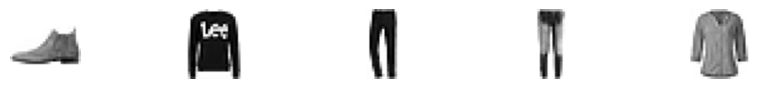

In [1]:
# Import Fashion MNIST
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256. + 0.5/256
example_x = x_test[:1000]
example_y = y_test[:1000]

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt',
    'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

batch_size = 32
x_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, x_train))\
    .batch(batch_size=batch_size)
x_test = tf.data.Dataset.from_tensor_slices(tensors=(x_test, x_test))\
    .batch(batch_size=batch_size)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=[9, 1])
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X=example_x[i], cmap='binary')
    ax.axis('off')
fig.tight_layout()
fig.show()

In [2]:
# Define latent_size and the prior, p(z)
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

latent_size = 4
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(shape=latent_size))
prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float32>

In [3]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

# samples z_j from q(z|x_j)
# then computes log q(z_j|x_j) - log p(z_j)
event_shape = [28, 28]
encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=event_shape),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=16, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.MultivariateNormalTriL
        .params_size(event_size=latent_size)),
    tfp.layers.MultivariateNormalTriL(event_size=latent_size),
    # estimates KL[q(z|x)||p(z)]
    tfp.layers.KLDivergenceAddLoss(distribution_b=prior)
])

# See how `KLDivergenceAddLoss` affects `encoder.losses`
# encoder.losses before the network has received any inputs
encoder.losses

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [4]:
# Pass a batch of images through the encoder
encoder(inputs=example_x)
# See how encoder.losses has changed
encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6747286319732666>]

In [5]:
# Re-specify the encoder using `weight` and `test_points_fn`
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=event_shape),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=16, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.MultivariateNormalTriL
        .params_size(event_size=latent_size)),
    tfp.layers.MultivariateNormalTriL(event_size=latent_size),
    tfp.layers.KLDivergenceAddLoss(distribution_b=prior, use_exact_kl=False,
        weight=1.5, test_points_fn=lambda q: q.sample(sample_shape=10),
        test_points_reduce_axis=0) # estimates KL[q(z|x)||p(z)]
])

# (n_samples, batch_size, dim_z)
# z_{ij} is the ith sample for x_j (is at (i,j,:) in tensor of samples)
# is mapped to log q(z_{ij}|x_j) - log p(z_{ij})
# => tensor of KL divergences has shape (n_samples, batch_size)

# Pass a batch of images through the encoder
encoder(inputs=example_x)
# See how encoder.losses has changed
encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=1011.5181884765625>]

In [3]:
# Replacing `KLDivergenceAddLoss`  with `KLDivergenceRegularizer` in the previous (probabilistic) layer
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

divergence_regularizer = tfp.layers.KLDivergenceRegularizer(distribution_b=prior,
    use_exact_kl=False, test_points_fn=lambda q: q.sample(sample_shape=5),
    test_points_reduce_axis=0)

event_shape = [28, 28]
encoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=event_shape),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=16, activation=tf.keras.activations.relu),
    tf_keras.layers.Dense(units=tfp.layers.MultivariateNormalTriL
        .params_size(event_size=latent_size)),
    tfp.layers.MultivariateNormalTriL(event_size=latent_size,
        activity_regularizer=divergence_regularizer)
])

# Pass a batch of images through the encoder
encoder(inputs=example_x)
# See how encoder.losses has changed
encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6683856844902039>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6587042808532715>]

In [4]:
# Specify the decoder, p(x|z)
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import tensorflow_probability as tfp

decoder = tf_keras.Sequential(layers=[
    tf_keras.Input(shape=latent_size),
    tf_keras.layers.Dense(units=16, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=32, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid),
    tf_keras.layers.Dense(units=2*event_shape[0]*event_shape[1],
        activation=tf.keras.activations.exponential),
    tf_keras.layers.Reshape(target_shape=(event_shape[0], event_shape[1], 2)),
    tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
        tfp.distributions.Independent(distribution=tfp.distributions.Beta(
            concentration1=t[..., 0], concentration0=t[..., 1]),
            reinterpreted_batch_ndims=2))
])

decoder(inputs=encoder(inputs=example_x))

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[28, 28] dtype=float32>

In [5]:
# Connect the encoder and decoder to form the VAE
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

vae = tf_keras.Model(inputs=encoder.inputs, outputs=decoder(inputs=encoder.outputs))

# Define a loss that only estimates the expected reconstruction error,
# -E_{Z ~ q(z|x)}[log p(x|Z)]
def log_loss(x_true, p_x_given_z):
    return -tf.math.reduce_sum(input_tensor=p_x_given_z.log_prob(value=x_true))

# Compile the model
vae.compile(loss=log_loss, optimizer=tf_keras.optimizers.Adam())

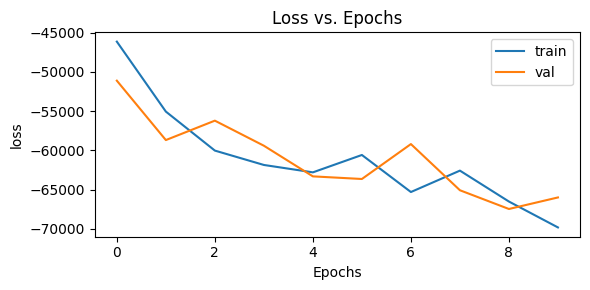

In [6]:
import matplotlib.pyplot as plt

# Fit the model
history = vae.fit(x=x_train, validation_data=x_test, epochs=10, verbose=False)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=[6, 3])
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='loss')
plt.title(label='Loss vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Generate an example reconstruction
example_reconstruction = vae(inputs=example_x).mean()
example_reconstruction.shape

TensorShape([1000, 28, 28])

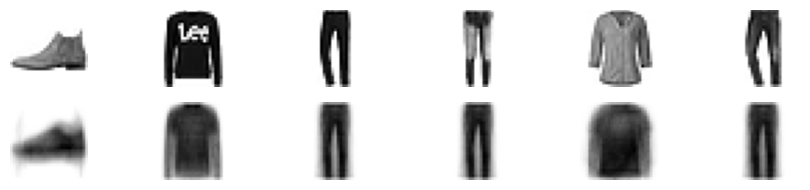

In [8]:
# Plot the example reconstructions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=[9, 2])
for j in range(6):
    axes[0, j].imshow(X=example_x[j], cmap='binary')
    axes[1, j].imshow(X=example_reconstruction[j], cmap='binary')
    axes[0, j].axis('off')
    axes[1, j].axis('off')
fig.tight_layout()
fig.show()